In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 3s 0us/step


In [5]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

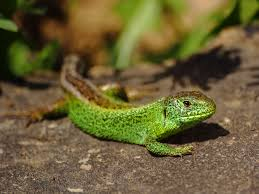

In [7]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/1.PNG', width=300,height=200) 

In [8]:
preprocessed_image = prepare_image('1.PNG')
predictions = mobile.predict(preprocessed_image)

In [9]:
results = imagenet_utils.decode_predictions(predictions)

40960/35363 [==================================] - 0s 0us/step


In [10]:
results

[[('n01693334', 'green_lizard', 0.49437806),
  ('n01687978', 'agama', 0.17275782),
  ('n01682714', 'American_chameleon', 0.059615035),
  ('n01685808', 'whiptail', 0.045738436),
  ('n01749939', 'green_mamba', 0.043445952)]]

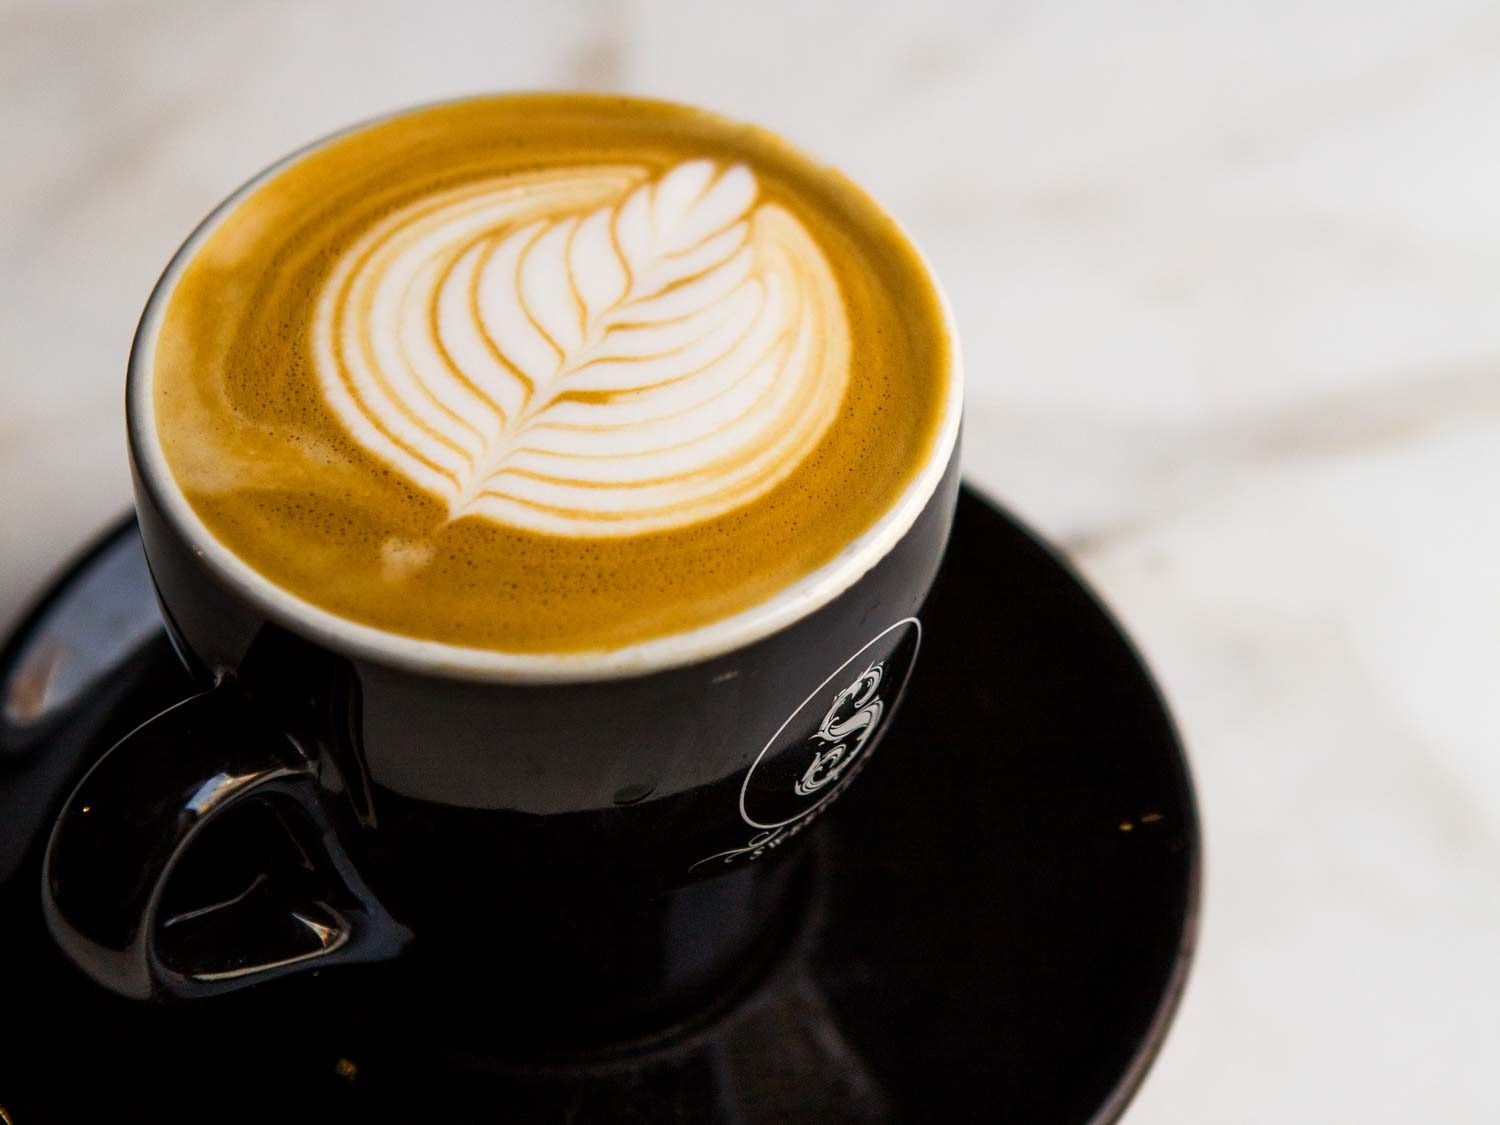

In [11]:
Image(filename='data/MobileNet-samples/2.PNG', width=300,height=200)

In [12]:
preprocessed_image = prepare_image('2.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)

In [13]:
results

[[('n07920052', 'espresso', 0.999653),
  ('n07930864', 'cup', 0.0002515386),
  ('n03063599', 'coffee_mug', 2.9195977e-05),
  ('n03063689', 'coffeepot', 2.5860132e-05),
  ('n07836838', 'chocolate_sauce', 5.4523757e-06)]]

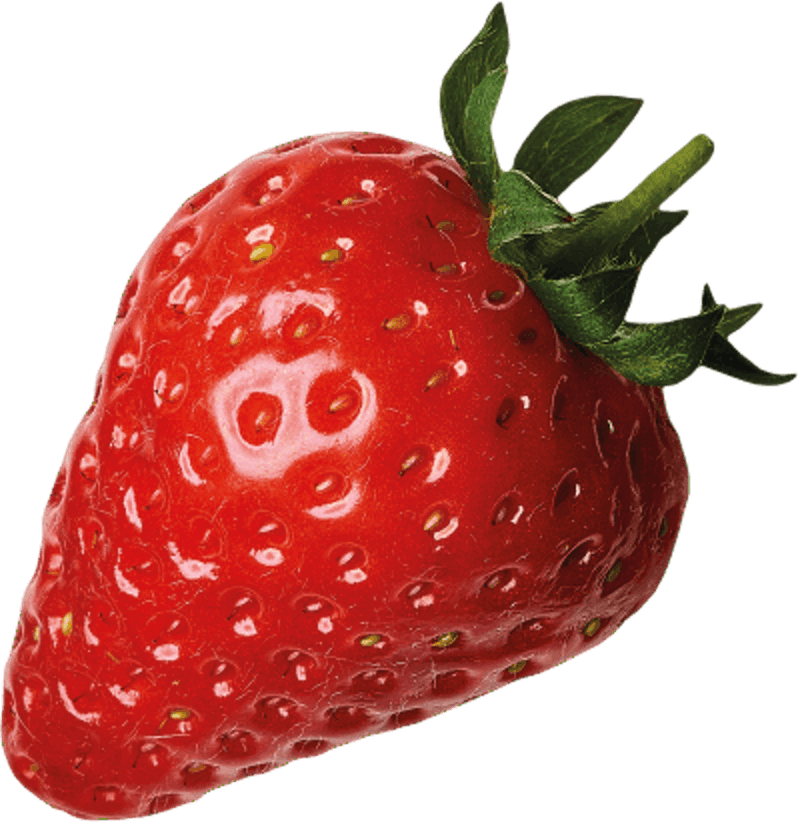

In [14]:
Image(filename='data/MobileNet-samples/3.PNG', width=300,height=200)

In [16]:
preprocessed_image = prepare_image('3.PNG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)

/usr/local/anaconda3/envs/keras_env/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [17]:
results

[[('n07745940', 'strawberry', 0.9989697),
  ('n07747607', 'orange', 0.000365654),
  ('n07749582', 'lemon', 0.00016288558),
  ('n13040303', 'stinkhorn', 0.00011624266),
  ('n12998815', 'agaric', 6.7348374e-05)]]

In [18]:
# Organize data into train, valid, test dirs
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [19]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


### modify model

In [20]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [21]:
x = mobile.layers[-6].output

In [22]:
output = Dense(units=10, activation='softmax')(x)

In [23]:
model = Model(inputs=mobile.input, outputs=output)

In [24]:
# 23 gives better result
for layer in model.layers[:-23]:
    layer.trainable = False

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [26]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Train for 172 steps, validate for 30 steps
Epoch 1/30
172/172 - 81s - loss: 0.8164 - accuracy: 0.7482 - val_loss: 1.2359 - val_accuracy: 0.5800
Epoch 2/30
172/172 - 78s - loss: 0.1121 - accuracy: 0.9907 - val_loss: 0.8638 - val_accuracy: 0.7367
Epoch 3/30
172/172 - 77s - loss: 0.0404 - accuracy: 0.9994 - val_loss: 0.7393 - val_accuracy: 0.7600
Epoch 4/30
172/172 - 70s - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.6544 - val_accuracy: 0.8100
Epoch 5/30
172/172 - 69s - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.6067 - val_accuracy: 0.8300
Epoch 6/30
172/172 - 68s - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.5848 - val_accuracy: 0.8267
Epoch 7/30
172/172 - 82s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.5531 - val_accuracy: 0.8333
Epoch 8/30
172/172 - 70s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.5187 - val_accuracy: 0.8400
Epoch 9/30
172/172 - 69s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.4933 - val_accuracy: 0.8567
Epoch 10/30
172/172 - 72s - loss: 0.0039 - accur

In [31]:
test_labels = test_batches.classes

In [32]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [33]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [1 0 1 0 1 0 2 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


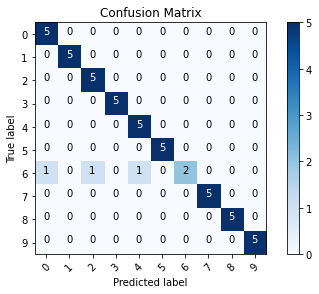

In [36]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')